In [1]:
import nibabel as nib
import numpy as np
import os

flat_data = []
ages = []
sexes = []
dementiaClass = []
non_zeros = np.load('non_zeros.npy')
fails = 0
rootDir = 'data'
dirName, subdirList, fileList = os.walk(rootDir).next()
for f in sorted(fileList):
    if "MR1" not in f: continue
    if "txt" in f: 
        sessionID = f.split('.')[0]
        with open(rootDir + "/" + f) as metadataFile:
            for line in metadataFile:
                if "AGE:" in line:
                    ages.append(int(list(filter(None, line.split()))[1]))
                elif "M/F:" in line:
                    sexes.append(list(filter(None, line.split()))[1])
                elif "CDR" in line:
                    try:
                        dementiaClass.append(int(list(filter(None, line.split()))[1]))
                    except:
                        fails += 1
                        dementiaClass.append(-1)
                    break
                
    elif "img" in f:
        data = nib.load(rootDir + "/" + f).get_data()
        #flat_data.append(data.flatten(order='C')[non_zeros])
        flat_data.append(data.flatten(order='F')[non_zeros])

flat_data_np = np.array(flat_data)
ages = np.array(ages, dtype='float64')
dementiaClass = np.array(dementiaClass)
                                
# WARNING: UNCOMMENTING THE FOLLOWING LINES WILL OVERWRITE YOUR BACKUPS

#np.save('flat_data2', flat_data_np)
#np.save('ages2', ages)
#np.save('sexes2', sexes)
#np.save('dementia', dementiaClass)

In [1]:
import numpy as np

ages = np.load('ages.npy')
#sexes = np.load('sexes.npy')
flat_data_np = np.load('flat_data.npy')

In [2]:
# finding items, that are equal everywhere
notTheSame = np.where(np.not_equal(flat_data_np[0], flat_data_np[1]))[0]
for element in flat_data_np:
    inds = np.where(np.not_equal(flat_data_np[0], flat_data_np[1]))[0]
    notTheSame = np.intersect1d(notTheSame, inds)
    
flat_data_filtered = flat_data_np[:,notTheSame]
flat_data_np = None
notTheSame = None # freeing up some memory
flat_data_filtered.shape

(416, 1420948)

In [50]:
from sklearn.feature_selection import SelectKBest, chi2

X = SelectKBest(chi2, k=200).fit_transform(flat_data_filtered, ages)
np.save('X', X)

In [5]:
from sklearn.decomposition import IncrementalPCA,FactorAnalysis
import matplotlib.pyplot as plt
%matplotlib inline

#transformer = IncrementalPCA(batch_size=105, n_components=100)
transformer = FactorAnalysis(n_components=100)
model = transformer.fit(flat_data_filtered, ages)
#plt.plot(model.explained_variance_)

AttributeError: 'FactorAnalysis' object has no attribute 'explained_variance_'

In [7]:
transformedData = model.transform(flat_data_filtered)
np.save('X',transformedData)

(array([  2.,   2.,  15.,  11.,  15.,  17.,  29.,  16.,  13.,  15.]),
 array([ 33. ,  39.1,  45.2,  51.3,  57.4,  63.5,  69.6,  75.7,  81.8,
         87.9,  94. ]),
 <a list of 10 Patch objects>)

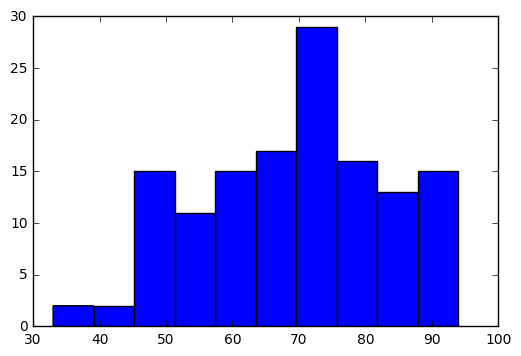

In [13]:
#transformedData = np.load('transformedData2.npy')
import matplotlib.pyplot as plt
%matplotlib inline
#dementiaClass = np.array(dementiaClass)
plt.hist(ages[np.where(dementiaClass == 0)])
#dementiaClass.dtype
#min(transformedData[:,4]), max(transformedData[:,4])